In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

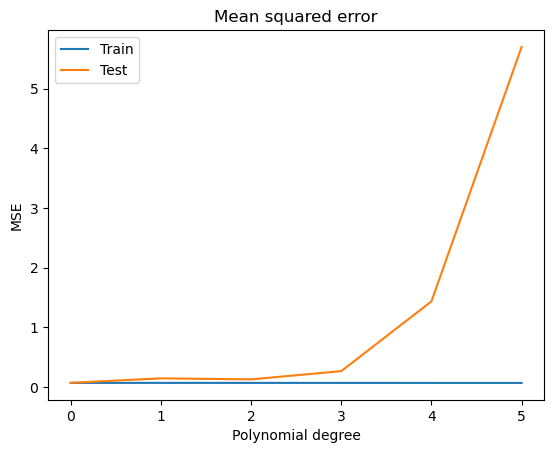

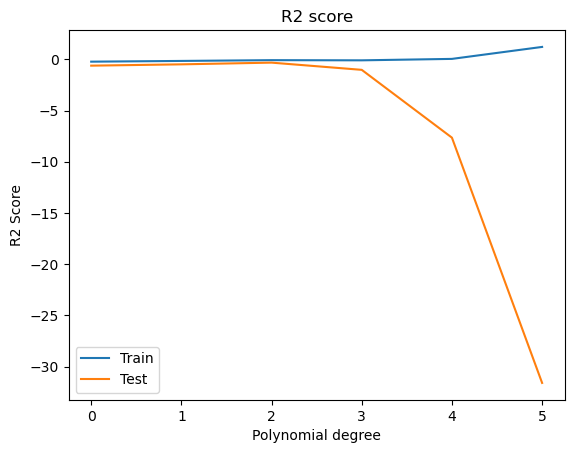

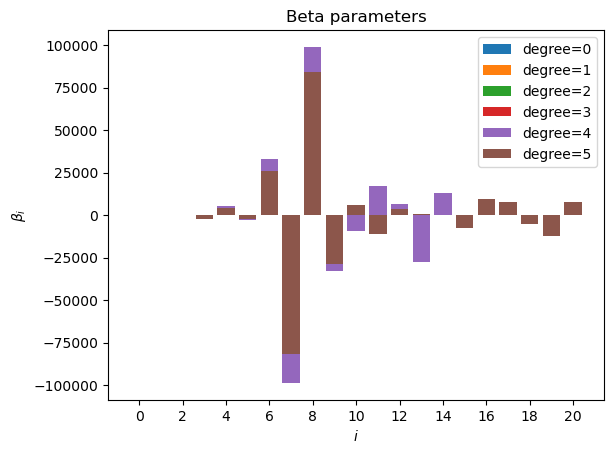

In [11]:
"""
Created on 26.09.2023
"""

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


def FrankeFunction(x, y):
    term1 = 0.75 * np.exp(-(0.25 * (9 * x - 2)**2) - 0.25 * ((9 * y - 2)**2))
    term2 = 0.75 * np.exp(-((9 * x + 1)**2) / 49.0 - 0.1 * (9 * y + 1))
    term3 = 0.5 * np.exp(-(9 * x - 7)**2 / 4.0 - 0.25 * ((9 * y - 3)**2))
    term4 = -0.2 * np.exp(-(9 * x - 4)**2 - (9 * y - 7)**2)
    return term1 + term2 + term3 + term4


def create_X(x, y, n):
    """Returns the design matrix X from coordinates x and y with n polynomial degrees."""
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)

    N = len(x)
    l = int((n + 1) * (n + 2) / 2)  # Number of elements in beta
    X = np.ones((N, l))

    for i in range(1, n + 1):
        q = int(i * (i + 1) / 2)
        for k in range(i + 1):
            X[:, q + k] = (x**(i - k)) * (y**k)

    return X


def MSE(y, y_tilde):
    """Returns the mean squared error of the two arrays."""
    return np.mean((y - y_tilde)**2)


def R2_score(y, y_tilde):
    """Returns the R2 score of the two arrays."""
    return 1 - np.sum((y - y_tilde)**2) / np.sum((y - np.mean(y))**2)


# PARAMETERS
N = 1000  # number of data points
maxdegree = 6  # max polynomial degree for plotting

"""
# Figure output directory
RESULTS_DIR = Path("../results").resolve()
FIGURES_DIR = RESULTS_DIR / "figures"

# Create them if they dont exist
if not RESULTS_DIR.exists():
    RESULTS_DIR.mkdir()

if not FIGURES_DIR.exists():
    FIGURES_DIR.mkdir()
"""

# Create data set
np.random.seed(2023)
x = np.sort(np.random.uniform(0, 1, N))
y = np.sort(np.random.uniform(0, 1, N))

# Get franke function with noise
noise = np.random.normal(0, 0.1, x.shape)
z = FrankeFunction(x, y) + noise

scaler = StandardScaler()

degrees = np.arange(0, maxdegree, 1)
train_mse = np.empty(degrees.shape)
test_mse = np.empty_like(train_mse)
train_r2 = np.empty_like(train_mse)
test_r2 = np.empty_like(train_mse)
beta_arr = []



# Iterate through all the different polynomial degrees
for degree in degrees:
    
    # Create design matrix X
    X = create_X(x, y, n=degree)  # intercept included

    """ Implementing cross validation for n_folds. Using the KFold from 
        sklearn.model_selection to split the data into two pieces
        train and test, given the input value n_splits which determines how many folds 
        with train and test pairs are created. 
    
        The loops uses two iterators train and test to loop through KFold and extracts 
        the indexes for the train and test arrays. Thus the iterators are essentially 
        extracting the elements indexes of the matrix. Inspired from (codebasics, 2019)
    """
    degrees_fold = np.arange(0, maxdegree, 1)
    train_mse_fold = np.empty(degrees.shape)
    test_mse_fold = np.empty_like(train_mse)
    train_r2_fold = np.empty_like(train_mse)
    test_r2_fold = np.empty_like(train_mse)

    n_folds = 5
    kf = KFold(n_splits=n_folds)
    for train, test in kf.split(X):
        X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]
        
        # Scale data
        scaler.fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)
    
        # Ordinary least squares linear regression
        beta = np.linalg.pinv(X_train_scaled.T @ X_train_scaled) @ X_train_scaled.T @ z_train
        z_tilde = X_train_scaled @ beta
        z_predict = X_test_scaled @ beta

        # Store the MSE and R2 values
        train_mse_fold[degree] = MSE(z_train, z_tilde)
        test_mse_fold[degree] = MSE(z_test, z_predict)
        train_r2_fold[degree] = R2_score(z_train, z_tilde)
        test_r2_fold[degree] = R2_score(z_test, z_predict)

    

    
    # Store beta value for plotting
    beta_arr.append(beta)
    
    # Store the MSE and R2 values
    train_mse[degree] = np.mean(train_mse_fold)
    test_mse[degree] = np.mean(test_mse_fold)
    train_r2[degree] = np.mean(train_r2_fold)
    test_r2[degree] = np.mean(test_r2_fold)


# Plot the MSE as function of poly. degree
plt.plot(degrees, train_mse, label="Train")
plt.plot(degrees, test_mse, label="Test")
plt.legend()
plt.title("Mean squared error")
plt.xlabel("Polynomial degree")
plt.ylabel("MSE")
#plt.savefig(FIGURES_DIR / "part_a_MSE.png")
plt.show()
# Plot R2 scores as function of poly. degree 
plt.plot(degrees, train_r2, label="Train")
plt.plot(degrees, test_r2, label="Test")
plt.legend()
plt.title("R2 score")
plt.xlabel("Polynomial degree")
plt.ylabel("R2 Score")
#plt.savefig(FIGURES_DIR / "part_a_R2.png")
plt.show()
# Now plot the beta parameters 
for degree in degrees:
    plt.bar(
            range(beta_arr[degree].size),  # indices
            beta_arr[degree],
            label=f"{degree=}",
    )
plt.legend()
plt.xticks(np.arange(plt.xlim()[1], step=2))
plt.title("Beta parameters")
plt.xlabel("$i$")
plt.ylabel(r"$\beta_i$")
#plt.savefig(FIGURES_DIR / "part_a_beta_params.png")
plt.show()